# Predicting heart disease using machine learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation


## 1. Problem Definition

In a statement,

> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2. Data

The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/datasets/sumaiyatasmeem/heart-disease-classification-dataset

## 3. Evaluation

> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

## Features

* age
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
colored vessel means the doctor can see the blood passing through
the more blood movement the better (no clots)
* thal - thalium stress result
* target - have disease or not (1=yes, 0=no) (= the predicted attribute)



# Preparing the tools
Python libraries used for data analysis and manipulation: pandas, matplotlib, numpy 

In [3]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay 

## Load data

In [4]:
df = pd.read_csv("data/heart-disease.csv")
df.shape # (rows, columns)

(303, 14)

<Axes: xlabel='target'>

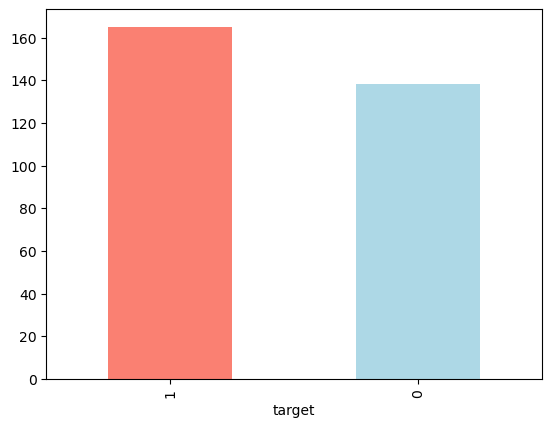

In [5]:
df["target"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]) # how many of each target class

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df.isna().sum() 
# no missing values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

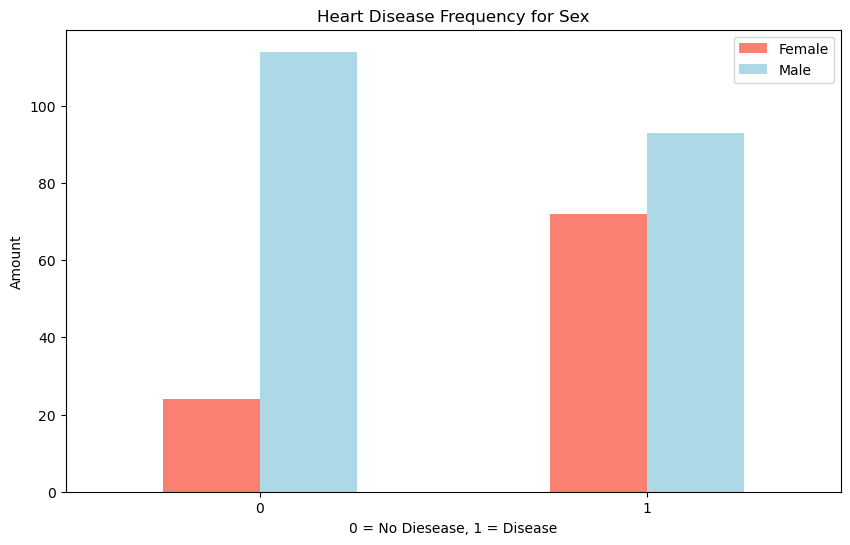

In [8]:
# compare the target column with the sex column
pd.crosstab(df.target, df.sex).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"])

plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Diesease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0);

### Age vs Max Heart Rate for Heart Disease

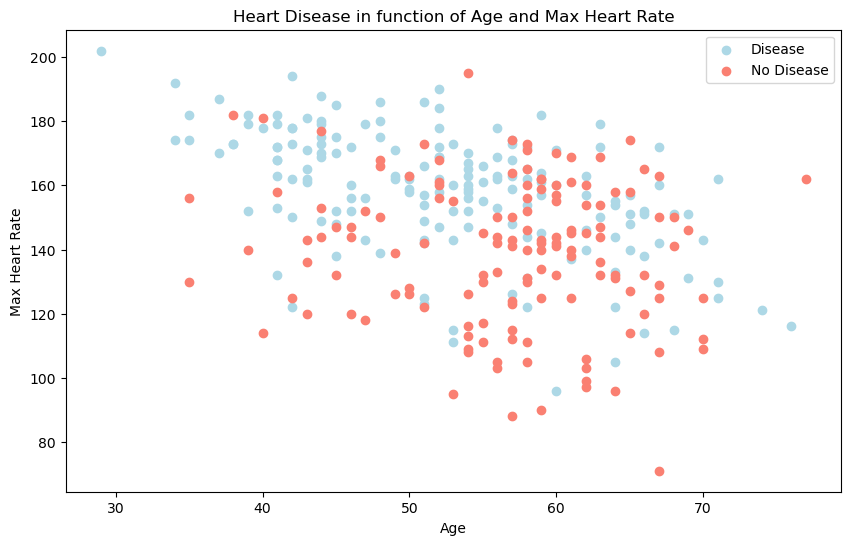

In [9]:
# thalach: maximum heart rate achieved 
# target: 1=heart disease, 0=no heart disease

# Create another figure
plt.figure(figsize=(10, 6))

# Scatter with positive examples
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c="lightblue")

# Scatter with negative examples
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c="salmon")

# Add some helpful info
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

### Heart Disease Frequency per Chest Pain Type

* cp - chest pain type
    - 0: Typical angina: chest pain related decrease blood supply to the heart
    - 1: Atypical angina: chest pain not related to heart
    - 2: Non-anginal pain: typically esophageal spasms (non heart related)
    - 3: Asymptomatic: chest pain not showing signs of disease

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

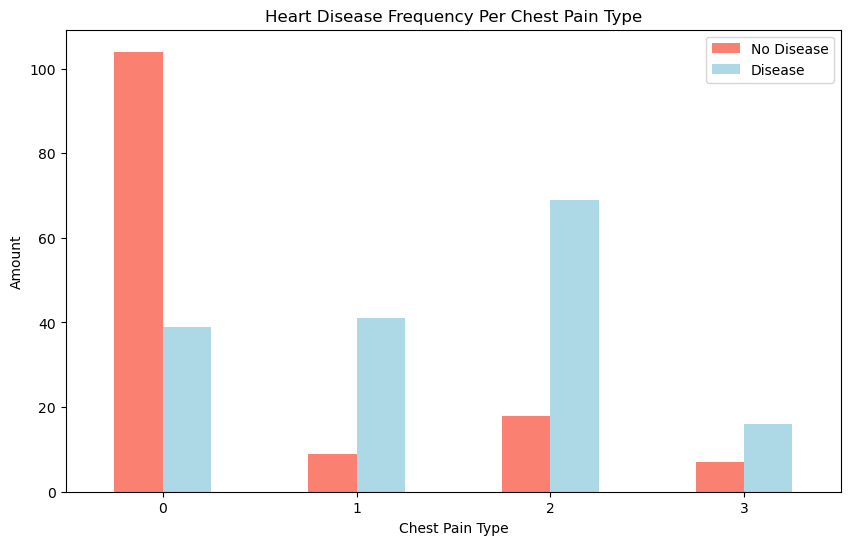

In [10]:
pd.crosstab(df.cp, df.target).plot(kind="bar", 
                                   figsize=(10,6),
                                  color=["salmon", "lightblue"])

# Add some communication
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation=0)

### Correlation Matrix

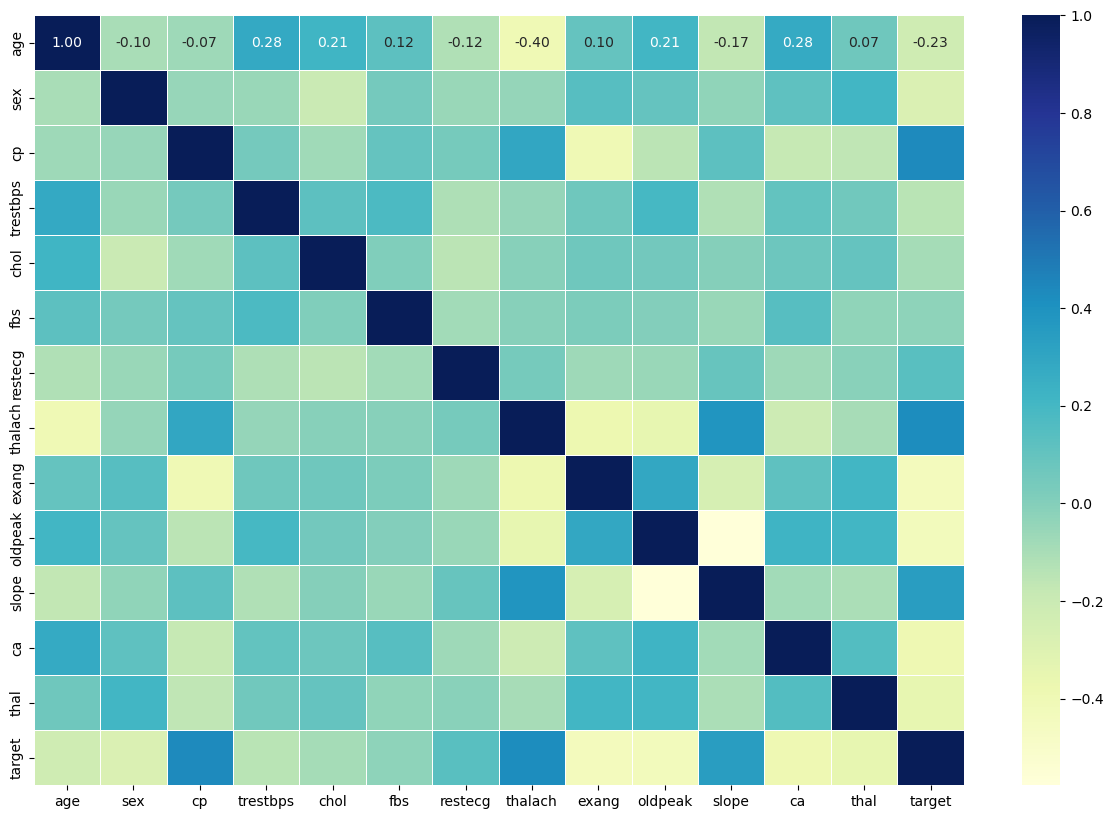

In [12]:
# correlation between columns
# val=1 means the values are equal
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

In [13]:
# Split data into X and y
X= df.drop("target", axis=1)
y=df["target"]

In [19]:
# split data into train and test sets
np.random.seed(42)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)


### Modeling

We're going to try 3 different machine learning models:

* Logistic Regression
* K-Nearest Neighbours Classifier
* Random Forest Classifier

In [29]:
# create a model dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# function to fit and score all the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [30]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/Users/mrinmoyeemishra/Desktop/ml_sample_project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

### Model Comparison

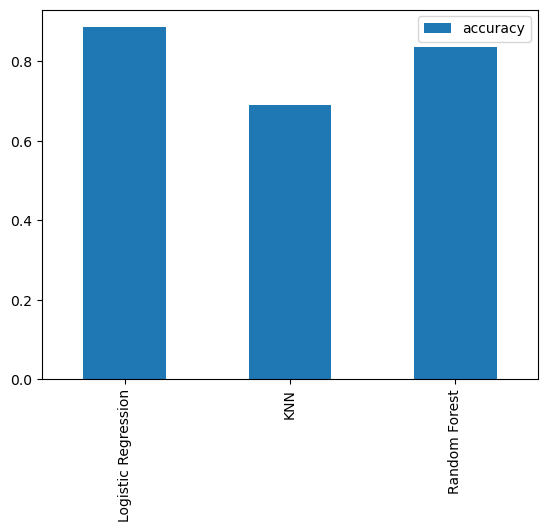

In [31]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

### Hyperparameter tuning (by hand)

In [34]:
# tune KNN since it was the worst performing model

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

In [35]:
train_scores

[1.0,
 0.8099173553719008,
 0.7727272727272727,
 0.743801652892562,
 0.7603305785123967,
 0.7520661157024794,
 0.743801652892562,
 0.7231404958677686,
 0.71900826446281,
 0.6942148760330579,
 0.7272727272727273,
 0.6983471074380165,
 0.6900826446280992,
 0.6942148760330579,
 0.6859504132231405,
 0.6735537190082644,
 0.6859504132231405,
 0.6652892561983471,
 0.6818181818181818,
 0.6694214876033058]

In [36]:
test_scores

[0.6229508196721312,
 0.639344262295082,
 0.6557377049180327,
 0.6721311475409836,
 0.6885245901639344,
 0.7213114754098361,
 0.7049180327868853,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.7540983606557377,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.6885245901639344,
 0.7213114754098361,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.6557377049180327]

Maximum KNN score on the test data: 75.41%


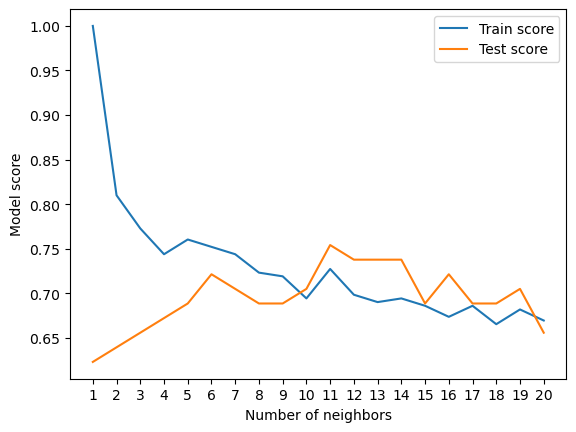

In [37]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")


### Hyperparameter tuning with RandomizedSearchCV

We are going to tune:
* LogisticRegression()
* RandomForestClassifier()

... using RandomizedSearchCV

In [38]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [39]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [40]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [41]:
rs_log_reg.score(X_test, y_test)

0.8852459016393442

In [42]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [43]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [44]:
rs_rf.score(X_test, y_test)

0.8688524590163934

### Hyperparamenter Tuning with GridSearchCV

In [45]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [46]:
# Check the best hyperparmaters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [47]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(X_test, y_test)

0.8852459016393442

### Evaluting our tuned machine learning classifier, beyond accuracy
- ROC curve and AUC score
- Confusion matrix
- Classification report
- Precision
- Recall
- F1-score
... and it would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [48]:
# make predictions with the tuned model
y_preds = gs_log_reg.predict(X_test)

In [51]:
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [62]:
# plot ROC curve and calculate AUC metric
# ROC curve (receiver operating characteristic curve) 
# a graph showing the performance of a classification model at all classification thresholds. 
# This curve plots two parameters: True Positive Rate. False Positive Rate.
plot_roc_curve(gs_log_reg,X_test, y_test)

NameError: name 'plot_roc_curve' is not defined

In [63]:
# Confusion matrix
# a table with two rows and two columns 
# that reports the number of true positives, false negatives, false positives, and true negatives

print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


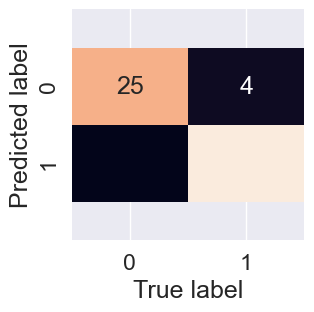

In [64]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_conf_mat(y_test, y_preds)

In [65]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Calculate evaluation metrics using cross-validation

We're going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using cross_val_score().

In [66]:
# Check best hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [68]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

In [69]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc


array([0.81967213, 0.90163934, 0.8852459 , 0.88333333, 0.75      ])

In [70]:
cv_acc = np.mean(cv_acc)
cv_acc

0.8479781420765027

In [77]:
# Cross-validated precision
# Precision is a metric that gives you the proportion of true positives 
# to the amount of total positives that the model predicts.
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.8215873015873015

In [75]:
# Cross-validated recall
# Recall  focuses on how good the model is at finding all the positives. 
# Recall is also called true positive rate
cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.9272727272727274

In [76]:
# Cross-validated f1-score
# F1 Score is a measure that combines recall and precision.
cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.8705403543192143

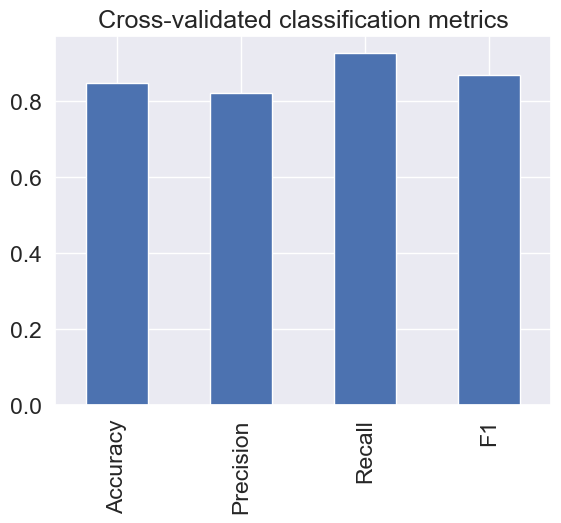

In [74]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

### Feature Importance

Which features contributed most to the outcomes of the model and how did they contribute?

Finding feature importance is different for each machine learning model. One way to find feature importance is to search for "(MODEL NAME) feature importance".

Let's find the feature importance for our LogisticRegression model...

In [78]:
# Fit an instance of LogisticRegression
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

clf.fit(X_train, y_train);

In [79]:
# Check coef_
clf.coef_

array([[ 0.00316728, -0.86044619,  0.6606706 , -0.01156993, -0.00166374,
         0.04386123,  0.31275813,  0.02459361, -0.60413061, -0.56862832,
         0.45051624, -0.63609879, -0.67663383]])

In [80]:
# Match coef's of features to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.003167276981166473,
 'sex': -0.8604461876496617,
 'cp': 0.6606705956924419,
 'trestbps': -0.011569931456373254,
 'chol': -0.0016637425660326452,
 'fbs': 0.04386123481563001,
 'restecg': 0.3127581278180605,
 'thalach': 0.02459361121787892,
 'exang': -0.6041306062021752,
 'oldpeak': -0.5686283181242949,
 'slope': 0.4505162370067001,
 'ca': -0.6360987949046014,
 'thal': -0.6766338344936489}

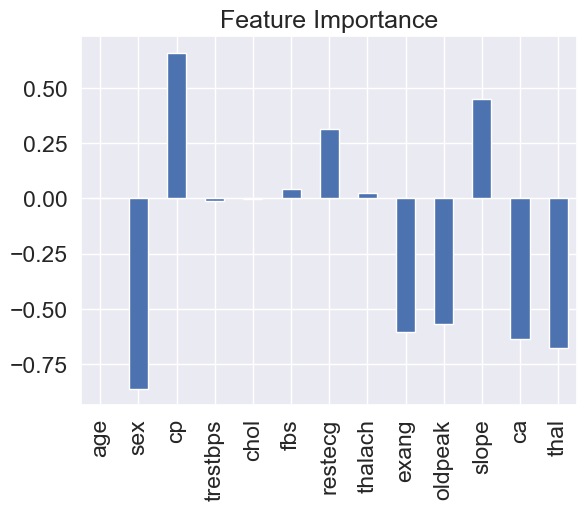

In [81]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

In [82]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


In [84]:
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


slope - the slope of the peak exercise ST segment

- 0: Upsloping: better heart rate with excercise (uncommon)
- 1: Flatsloping: minimal change (typical healthy heart)
- 2: Downslopins: signs of unhealthy heart